In [1]:
import pandas as pd
from os.path import join
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import ttest_rel
import numpy as np
import statsmodels.api as sm
import pandas as pd
import pickle as pkl 

pd.options.display.float_format = '{:.3f}'.format

In [2]:
#standardize plots
def custom_plots(ax=None):
    if ax is None:
        ax = plt.gca()
    ax.grid(False)
    ax.spines["bottom"].set_color("black")
    ax.spines["left"].set_color("black")
    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)
    plt.gca().yaxis.set_ticks_position('left')
    plt.gca().xaxis.set_ticks_position('bottom')

In [3]:
DIR = "/raid5pool/tank/luehring/german_newsguard_tweets/"
DATA_DIR = DIR + "discussions/"
PAPER_DIR = "/home/luehring/emomis/emomis-discussion-paper/"
with open(join(DIR, "dtypes_config.pickle"), "rb") as file:
    DTYPES = pkl.load(file)

In [4]:
DF = pd.read_csv(join(DATA_DIR, "same_replies_aggregates_one.csv"), 
                 dtype=DTYPES
                 )
DF.Rating.value_counts()

0.0    2572
1.0    2572
Name: Rating, dtype: int64

In [5]:
DF.same_author_id.nunique()

2572

In [6]:
DF.same_id.nunique()

5144

In [ ]:
DF.conversation_id.nunique()

In [44]:
# create categorical variable for the rating
DF["Rating_cat"] = DF["Rating"]\
    .replace({"0.0": "Trustworthy", "1.0": "Untrustworthy"})

DF.Rating_cat.value_counts()

Trustworthy      2572
Untrustworthy    2572
Name: Rating_cat, dtype: int64

In [45]:
# select columns
same_users = DF[["same_author_id",
                   "Rating",
                   "Rating_cat",
                   "anger_first", "disgust_first", 
                   "fear_first", "sadness_first", 
                   "joy_first", "hope_first", "pride_first"]]

In [46]:
emotions = ["anger_first", "disgust_first", 
            "fear_first", "sadness_first", 
            "joy_first", "hope_first", "pride_first"]

In [47]:
means = []

for emotion in emotions:
    same_users_long = same_users\
                    .pivot_table(
                        index='same_author_id', 
                        columns='Rating_cat', 
                        values=emotion)\
                    .reset_index()

    # calculate descriptives
    mean_trustworthy = same_users_long["Trustworthy"].mean()
    mean_untrustworthy = same_users_long["Untrustworthy"].mean()
    std_trustworthy = same_users_long["Trustworthy"].std()
    std_untrustworthy = same_users_long["Untrustworthy"].std()
    
    means.append({"Emotion": emotion.replace("_same", "").capitalize(),
                    "M_trustworthy": same_users_long["Trustworthy"].mean(),
                    "M_untrustworthy": same_users_long["Untrustworthy"].mean(),
                    "STD_trustworthy": same_users_long["Trustworthy"].std(),
                    "STD_untrustworthy": same_users_long["Untrustworthy"].std()})

means = pd.DataFrame(means)
means

,Emotion,M_trustworthy,M_untrustworthy,STD_trustworthy,STD_untrustworthy
0,Anger_first,0.362,0.371,0.427,0.431
1,Disgust_first,0.017,0.024,0.091,0.116
2,Fear_first,0.012,0.020,0.072,0.108
3,Sadness_first,0.021,0.018,0.112,0.101
4,Joy_first,0.032,0.034,0.157,0.161
5,Hope_first,0.008,0.006,0.067,0.053
6,Pride_first,0.008,0.005,0.065,0.040


In [48]:
coeffs = []
models = []
means = []
bootstrap_coeffs_merged = []

for emotion in emotions:
    pivot = same_users.pivot_table(index='same_author_id', 
                                   columns='Rating_cat', 
                                   values=emotion).reset_index()
    pivot = pivot.dropna()
    
    mean_trustworthy = pivot['Trustworthy'].mean()
    mean_untrustworthy = pivot['Untrustworthy'].mean()
    std_trustworthy = pivot['Trustworthy'].std()
    std_untrustworthy = pivot['Untrustworthy'].std()

    pivot["PC"] = ((pivot["Untrustworthy"] - pivot["Trustworthy"]) / pivot["Trustworthy"]) * 100

    long_format = pivot.melt(id_vars=['same_author_id'], 
                             value_vars=[
                                 'Untrustworthy', 'Trustworthy'],
                             var_name='Rating_cat', 
                             value_name='Emotion')
    long_format['Group'] = long_format['Rating_cat']\
        .map({'Trustworthy': 0, 'Untrustworthy': 1})
    long_format = long_format.dropna()
    long_format['Group'] = long_format['Group']\
        .astype("category")

    model = sm.OLS(long_format['Emotion'], 
                   sm.add_constant(long_format['Group'].astype(float)))\
                    .fit()
    models.append(model)
    

    coeff = model.params['Group']  
    t_statistic = model.tvalues['Group']
    p_value = model.pvalues['Group']
    ci_lower, ci_upper = model.conf_int().loc['Group']  
    r2 = model.rsquared

    means.append({"Emotion": emotion.replace("_first", "").capitalize(),
                  "M_trustworthy": mean_trustworthy,
                  "M_untrustworthy": mean_untrustworthy,
                  "STD_trustworthy": std_trustworthy,
                  "STD_untrustworthy": std_untrustworthy})
    
    coeffs.append({"Emotion": emotion.replace("_first", "").capitalize(),
                        "Estimate": coeff,
                        "p": p_value,
                        "R2": r2,
                        "Change": round((coeff / mean_trustworthy) * 100, 2)
                        })
    
    n = len(long_format)
    bootstrap_coeffs = []
    for i in range(10000):
        sample = long_format.sample(n, replace=True)
        model = sm.OLS(sample['Emotion'], sm.add_constant(sample['Group'])).fit()
        bootstrap_coeffs.append(model.params['Group'])

    ci_lower, ci_upper = np.percentile(bootstrap_coeffs, [2.5, 97.5])
    coeffs[-1]["CI_Lower_boot"] = ci_lower
    coeffs[-1]["CI_Upper_boot"] = ci_upper
    
    # dump the models with pickle
    with open(join("./same_responders/", 
                   f"{emotion}_model.pickle"), "wb") as file:
        pkl.dump(model, file)
        
    # append the bootstrapped coefficients into one df
    bootstrap_coeffs_df = pd.DataFrame(bootstrap_coeffs, columns=["Estimate_boot"])
    bootstrap_coeffs_df["Emotion"] = emotion.replace("_first", "").capitalize()
    bootstrap_coeffs_merged.append(bootstrap_coeffs_df)

# save bootstrap results
bootstrap_coeffs_merged_df = pd.concat(bootstrap_coeffs_merged, ignore_index=True)
bootstrap_coeffs_merged_df.to_csv(join("./same_responders/", "same_coeffs_boot.csv"), index=False)

ols_coeffs = pd.DataFrame(coeffs)
ols_means = pd.DataFrame(means)
ols_coeffs

,Emotion,Estimate,p,R2,Change,CI_Lower_boot,CI_Upper_boot
0,Anger,0.009,0.461,0.000,2.430,-0.015,0.032
1,Disgust,0.007,0.012,0.001,44.250,0.002,0.013
2,Fear,0.007,0.004,0.002,59.190,0.002,0.012
3,Sadness,-0.003,0.349,0.000,-13.310,-0.009,0.003
4,Joy,0.002,0.729,0.000,4.730,-0.007,0.010
5,Hope,-0.001,0.423,0.000,-17.660,-0.005,0.002
6,Pride,-0.003,0.045,0.001,-39.450,-0.006,-0.000


In [49]:
ols_means

,Emotion,M_trustworthy,M_untrustworthy,STD_trustworthy,STD_untrustworthy
0,Anger,0.362,0.371,0.427,0.431
1,Disgust,0.017,0.024,0.091,0.116
2,Fear,0.012,0.020,0.072,0.108
3,Sadness,0.021,0.018,0.112,0.101
4,Joy,0.032,0.034,0.157,0.161
5,Hope,0.008,0.006,0.067,0.053
6,Pride,0.008,0.005,0.065,0.040


In [50]:
ols_coeffs.to_csv(join("./same_responders/", "same_coeffs_emotions.csv"), index=False)

In [51]:
coeffs_latex = ols_coeffs.copy()
coeffs_latex["95\%CI"] = coeffs_latex["CI_Lower_boot"].round(3).astype(str) + ", " + coeffs_latex["CI_Upper_boot"].round(3).astype(str)
coeffs_latex = coeffs_latex.drop(columns=["CI_Lower_boot", "CI_Upper_boot"])
coeffs_latex

,Emotion,Estimate,p,R2,Change,95\%CI
0,Anger,0.009,0.461,0.000,2.430,"-0.015, 0.032"
1,Disgust,0.007,0.012,0.001,44.250,"0.002, 0.013"
2,Fear,0.007,0.004,0.002,59.190,"0.002, 0.012"
3,Sadness,-0.003,0.349,0.000,-13.310,"-0.009, 0.003"
4,Joy,0.002,0.729,0.000,4.730,"-0.007, 0.01"
5,Hope,-0.001,0.423,0.000,-17.660,"-0.005, 0.002"
6,Pride,-0.003,0.045,0.001,-39.450,"-0.006, -0.0"


In [52]:
coeffs_latex.to_latex(join(PAPER_DIR, "tables", "same_coeffs_emotions.tex"), index=False)

/tmp/ipykernel_2872394/2468404443.py:1: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  coeffs_latex.to_latex(join(PAPER_DIR, "tables", "same_coeffs_emotions.tex"), index=False)


In [61]:
# take only Anger
anger_boot = bootstrap_coeffs_merged_df[bootstrap_coeffs_merged_df["Emotion"] == "Anger"]
np.percentile(anger_boot["Estimate_boot"], [2.5, 97.5])

array([-0.0148244 ,  0.03225081])

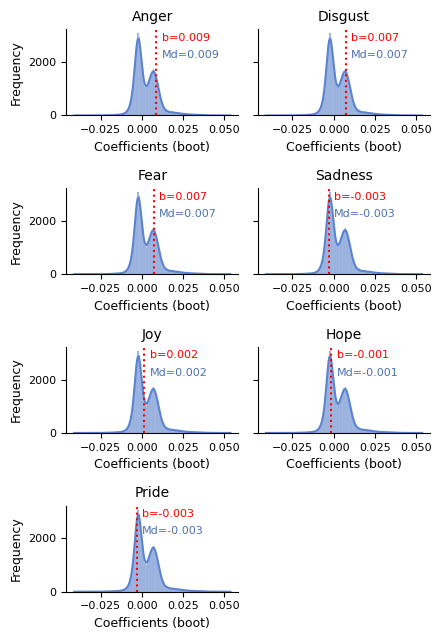

In [54]:
fig, ax = plt.subplots(4, 2, figsize=(4.5, 6.5),
                        sharex=False, sharey=True)

for i, emotion in enumerate(ols_coeffs["Emotion"].unique()):
    emo_row = ols_coeffs[ols_coeffs["Emotion"]==emotion]
    m_diff = emo_row["Estimate"].values[0]
    p_value = emo_row["p"].values[0]
    df = bootstrap_coeffs_merged_df[bootstrap_coeffs_merged_df["Emotion"] == emotion]
    median = df["Estimate_boot"].median()
    mean = df["Estimate_boot"].mean()
    sns.histplot(bootstrap_coeffs_merged_df["Estimate_boot"], 
                 ax=ax[i//2, i%2], color="#5A83D1", edgecolor="#4C72B0", kde=True)
    ax[i//2, i%2].set_title(emotion, fontsize=10)
    ax[i//2, i%2].set_xlabel("Coefficients (boot)", fontsize=9)
    ax[i//2, i%2].set_ylabel("Frequency", fontsize=9)
    ax[i//2, i%2].tick_params(axis="both", labelsize=8)
    ax[i//2, i%2].axvline(x=m_diff,
                            color="red",
                            linestyle=":")
    
    ax[i // 2, i % 2].text(
        m_diff + 0.03 * (ax[i // 2, i % 2]\
                        .get_xlim()[1] - ax[i // 2, i % 2]\
                        .get_xlim()[0]),  
        ax[i // 2, i % 2].get_ylim()[1] * 0.9,
        f"b={m_diff:.3f}", 
        color="red", 
        fontsize=8,
        verticalalignment='center'
    )

    ax[i // 2, i % 2].text(
        median + 0.03 * (ax[i // 2, i % 2]\
                        .get_xlim()[1] - ax[i // 2, i % 2]\
                        .get_xlim()[0]),  
        ax[i // 2, i % 2].get_ylim()[1] * 0.7,
        f"Md={median:.3f}", 
        color="#4C72B0", 
        fontsize=8,
        verticalalignment='center')
    
    custom_plots(ax=ax[i//2, i%2])
    
    # hide the last plot
    if i == 6:
        ax[3, 1].axis("off")

plt.tight_layout()

plt.savefig(join("./same_responders/" , 
                 "same_coeff_boot.pdf"), 
                 bbox_inches="tight", 
                 dpi=300)

plt.savefig(join(PAPER_DIR, "figures/"
                 "same_coeff_boot.pdf"), 
                 bbox_inches="tight", 
                 dpi=300)
plt.show()